In [5]:
import joblib
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import LeaveOneOut
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
# from envs.filtr_json_from_race import load_from_db
import sqlite3
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
class LSTMStatePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,n_steps_ahead, num_layers=1):
        super(LSTMStatePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # self.fc = nn.Linear(hidden_size, output_size * n_steps_ahead)

        self.heads = nn.ModuleList([
        nn.Linear(hidden_size, 2),  # progress
        nn.Linear(hidden_size, 1),  # fuel
        nn.Linear(hidden_size, 4),  # wear
        nn.Linear(hidden_size, 4),  # temp
        nn.Linear(hidden_size, 1)   # track wetness
        ])

        self.scaler_X = None
        self.scaler_Y = None
        self.n_steps_ahead = n_steps_ahead
        self.output_size = output_size

    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h_0, c_0))

        # Bierzemy ukryty stan z ostatniego kroku czasowego
        last_hidden = out[:, -1, :]  # shape [batch, hidden_size]

        # Każdy head przewiduje własną grupę cech
        outputs = [head(last_hidden) for head in self.heads]  

        # Łączymy wszystko w jeden wektor
        combined = torch.cat(outputs, dim=1)  # [B, 12]

      
        combined = combined.unsqueeze(1).repeat(1, self.n_steps_ahead, 1)
        

        return combined

def create_scalers(X,Y):

    cont_indices_x = slice(0, 19)   # continuous columns for X (0–18)
    cont_indices_y = slice(0, 12)   # continuous columns for Y (0–11)

    # Scale continuous features
    flat_x = np.vstack([x[:, cont_indices_x] for x in X])
    flat_y = np.vstack([y[:, cont_indices_y] for y in Y])

    scaler_X = MinMaxScaler().fit(flat_x)
    # scaler_Y = MinMaxScaler().fit(flat_y)
    scaler_Y = StandardScaler().fit(flat_y)
    return scaler_X, scaler_Y


def scale_input(X, Y, scaler_X, scaler_Y):
    cont_indices_x = slice(0, 19)   # continuous columns for X
    cont_indices_y = slice(0, 12)   # continuous columns for Y

    X_scaled_grouped = []
    Y_scaled_grouped = []

    for x_seq, y_seq in zip(X, Y):
        x_scaled = np.array(x_seq, dtype=float)
        x_scaled[:, cont_indices_x] = scaler_X.transform(x_seq[:, cont_indices_x])
        X_scaled_grouped.append(x_scaled)

        y_scaled = np.array(y_seq, dtype=float)
        y_scaled[:, cont_indices_y] = scaler_Y.transform(y_seq[:, cont_indices_y])
        Y_scaled_grouped.append(y_scaled)

    # Conversion to torch tensors
    # X_t = [torch.tensor(x, dtype=torch.float32) for x in X_scaled_grouped]
    # Y_cont_t = [torch.tensor(y[:, cont_indices_y], dtype=torch.float32) for y in Y_scaled_grouped]

    return X_scaled_grouped, Y_scaled_grouped

In [3]:
def load_data_from_db():
    
    """
    Load data so that each race is a separate sequence:
    X = [ [state1_race1, state2_race1, ...], [state1_race2, ...] ]
    Y = [ [next1_race1, next2_race1, ...], ... ]
    """
    conn = sqlite3.connect(
        "E:/pracadyp/Race-optimization-reinforcement-learning/data/db_states_for_regress/race_data_states.db"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT race_id, states_json FROM races ORDER BY race_id")
    rows = cursor.fetchall()
    conn.close()


    data = []

    for race_id, states_json in rows:
        states = json.loads(states_json)
        data.append(states)
    
    return data

def create_windows(sequence_x, sequence_y, window_size, n_steps_ahead=5):
    X, Y = [], []
    for t in range(1, len(sequence_x)):
        start = max(0, t - window_size)
        window = sequence_x[start:t]

        # padding na początku, jeśli okno krótsze niż window_size
        pad_len = window_size - len(window)
        if pad_len > 0:
            window = np.vstack([np.zeros((pad_len, sequence_x.shape[1])), window])
        X.append(window)

        # Y: wypełniamy zerami, jeśli końcówka wyścigu ma mniej niż n_steps_ahead
        y_window = sequence_y[t:t+n_steps_ahead]
        if y_window.shape[0] < n_steps_ahead:
            pad = np.zeros((n_steps_ahead - y_window.shape[0], sequence_y.shape[1]))
            y_window = np.vstack([y_window, pad])
        Y.append(y_window)

    return np.array(X), np.array(Y)

def create_x_y(data):
    X_grouped, Y_grouped = [], []

    for race in data:
        X_seq, Y_seq = [], []
        for i in range(len(race) - 1):
            X_seq.append(race[i][:-2])
            Y_seq.append(race[i + 1][:-25])
        
        # dodajemy każdy wyścig osobno
        X_grouped.append(np.array(X_seq, dtype=float))
        Y_grouped.append(np.array(Y_seq, dtype=float))

    return X_grouped, Y_grouped

Testing lr: 0.001
Using device: cuda
Epoch 1, current lr: 0.001000
Epoch 2, current lr: 0.001000
Epoch 3, current lr: 0.001000
Epoch 4, current lr: 0.001000
Epoch 5, current lr: 0.001000
Epoch 6, current lr: 0.001000
Epoch 7, current lr: 0.001000
Epoch 8, current lr: 0.000800
Epoch 9, current lr: 0.000800
Epoch 10, current lr: 0.000800
Epoch 11, current lr: 0.000800
Epoch 12, current lr: 0.000800
Epoch 13, current lr: 0.000800
Epoch 14, current lr: 0.000800
Epoch 15, current lr: 0.000800
Epoch 16, current lr: 0.000800
Epoch 17, current lr: 0.000800
Epoch 18, current lr: 0.000800
Epoch 19, current lr: 0.000800
Epoch 20, current lr: 0.000800
Epoch 21, current lr: 0.000800
Epoch 22, current lr: 0.000800
Epoch 23, current lr: 0.000800
Epoch 24, current lr: 0.000800
Epoch 25, current lr: 0.000800
Epoch 26, current lr: 0.000800
Epoch 27, current lr: 0.000640
Epoch 28, current lr: 0.000640
Epoch 29, current lr: 0.000640
Epoch 30, current lr: 0.000640
Epoch 31, current lr: 0.000640
Epoch 32, c

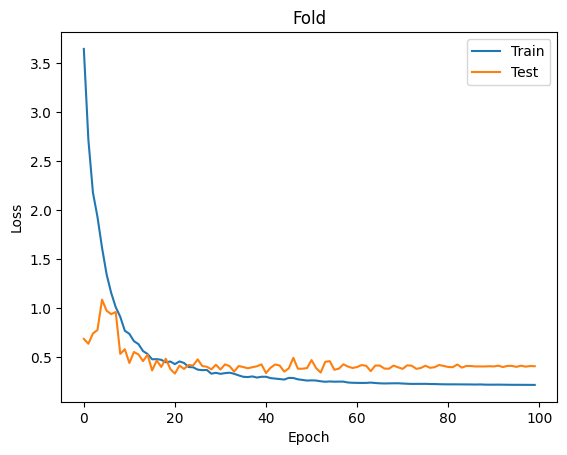

Testing lr: 0.001
Using device: cuda
Epoch 1, current lr: 0.001000
Epoch 2, current lr: 0.001000
Epoch 3, current lr: 0.001000
Epoch 4, current lr: 0.001000
Epoch 5, current lr: 0.001000
Epoch 6, current lr: 0.001000
Epoch 7, current lr: 0.001000
Epoch 8, current lr: 0.001000
Epoch 9, current lr: 0.001000
Epoch 10, current lr: 0.001000
Epoch 11, current lr: 0.001000
Epoch 12, current lr: 0.001000
Epoch 13, current lr: 0.001000
Epoch 14, current lr: 0.001000
Epoch 15, current lr: 0.001000
Epoch 16, current lr: 0.001000
Epoch 17, current lr: 0.001000
Epoch 18, current lr: 0.001000
Epoch 19, current lr: 0.001000
Epoch 20, current lr: 0.001000
Epoch 21, current lr: 0.001000
Epoch 22, current lr: 0.001000
Epoch 23, current lr: 0.001000
Epoch 24, current lr: 0.001000
Epoch 25, current lr: 0.001000
Epoch 26, current lr: 0.001000
Epoch 27, current lr: 0.001000
Epoch 28, current lr: 0.001000
Epoch 29, current lr: 0.000800
Epoch 30, current lr: 0.000800
Epoch 31, current lr: 0.000800
Epoch 32, c

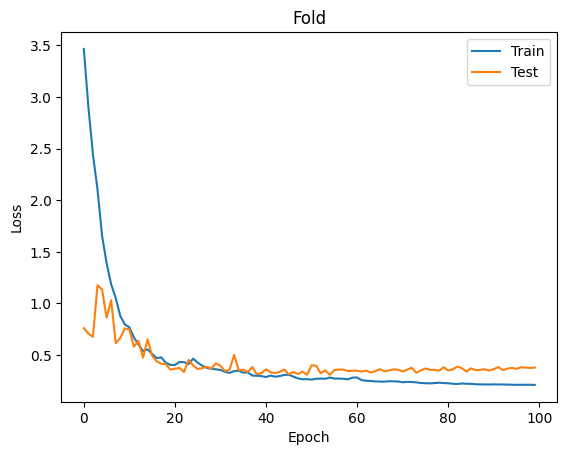

Testing lr: 0.001
Using device: cuda
Epoch 1, current lr: 0.001000
Epoch 2, current lr: 0.001000
Epoch 3, current lr: 0.001000
Epoch 4, current lr: 0.001000
Epoch 5, current lr: 0.001000
Epoch 6, current lr: 0.001000
Epoch 7, current lr: 0.001000
Epoch 8, current lr: 0.001000
Epoch 9, current lr: 0.001000
Epoch 10, current lr: 0.001000
Epoch 11, current lr: 0.000800
Epoch 12, current lr: 0.000800
Epoch 13, current lr: 0.000800
Epoch 14, current lr: 0.000800
Epoch 15, current lr: 0.000800
Epoch 16, current lr: 0.000800
Epoch 17, current lr: 0.000800
Epoch 18, current lr: 0.000800
Epoch 19, current lr: 0.000800
Epoch 20, current lr: 0.000800
Epoch 21, current lr: 0.000800
Epoch 22, current lr: 0.000800
Epoch 23, current lr: 0.000800
Epoch 24, current lr: 0.000800
Epoch 25, current lr: 0.000640
Epoch 26, current lr: 0.000640
Epoch 27, current lr: 0.000640
Epoch 28, current lr: 0.000640
Epoch 29, current lr: 0.000640
Epoch 30, current lr: 0.000640
Epoch 31, current lr: 0.000512
Epoch 32, c

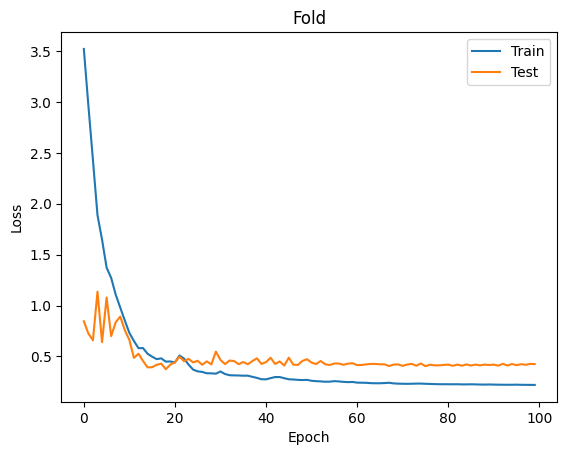

Testing lr: 0.0007
Using device: cuda
Epoch 1, current lr: 0.000700
Epoch 2, current lr: 0.000700
Epoch 3, current lr: 0.000700
Epoch 4, current lr: 0.000700
Epoch 5, current lr: 0.000700
Epoch 6, current lr: 0.000700
Epoch 7, current lr: 0.000700
Epoch 8, current lr: 0.000700
Epoch 9, current lr: 0.000700
Epoch 10, current lr: 0.000700
Epoch 11, current lr: 0.000700
Epoch 12, current lr: 0.000700
Epoch 13, current lr: 0.000700
Epoch 14, current lr: 0.000700
Epoch 15, current lr: 0.000700
Epoch 16, current lr: 0.000700
Epoch 17, current lr: 0.000700
Epoch 18, current lr: 0.000700
Epoch 19, current lr: 0.000700
Epoch 20, current lr: 0.000700
Epoch 21, current lr: 0.000700
Epoch 22, current lr: 0.000700
Epoch 23, current lr: 0.000700
Epoch 24, current lr: 0.000700
Epoch 25, current lr: 0.000700
Epoch 26, current lr: 0.000700
Epoch 27, current lr: 0.000700
Epoch 28, current lr: 0.000560
Epoch 29, current lr: 0.000560
Epoch 30, current lr: 0.000560
Epoch 31, current lr: 0.000560
Epoch 32, 

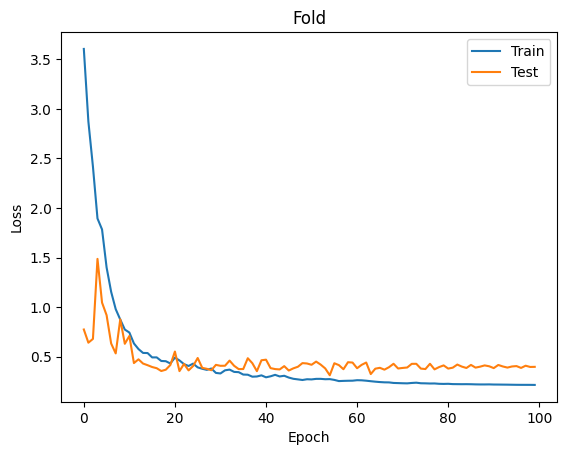

Testing lr: 0.0005
Using device: cuda
Epoch 1, current lr: 0.000500
Epoch 2, current lr: 0.000500
Epoch 3, current lr: 0.000500
Epoch 4, current lr: 0.000500
Epoch 5, current lr: 0.000500
Epoch 6, current lr: 0.000500
Epoch 7, current lr: 0.000500
Epoch 8, current lr: 0.000500
Epoch 9, current lr: 0.000500
Epoch 10, current lr: 0.000500
Epoch 11, current lr: 0.000500
Epoch 12, current lr: 0.000500
Epoch 13, current lr: 0.000500
Epoch 14, current lr: 0.000500
Epoch 15, current lr: 0.000500
Epoch 16, current lr: 0.000500
Epoch 17, current lr: 0.000500
Epoch 18, current lr: 0.000500
Epoch 19, current lr: 0.000500
Epoch 20, current lr: 0.000500
Epoch 21, current lr: 0.000500
Epoch 22, current lr: 0.000500
Epoch 23, current lr: 0.000400
Epoch 24, current lr: 0.000400
Epoch 25, current lr: 0.000400
Epoch 26, current lr: 0.000400
Epoch 27, current lr: 0.000400
Epoch 28, current lr: 0.000400
Epoch 29, current lr: 0.000400
Epoch 30, current lr: 0.000320
Epoch 31, current lr: 0.000320
Epoch 32, 

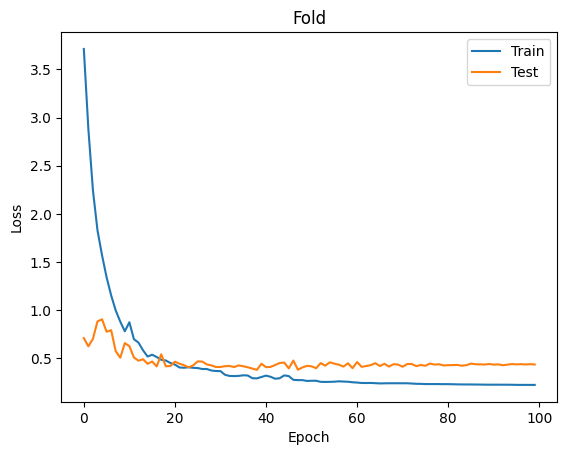

Testing lr: 0.0003
Using device: cuda
Epoch 1, current lr: 0.000300
Epoch 2, current lr: 0.000300
Epoch 3, current lr: 0.000300
Epoch 4, current lr: 0.000300
Epoch 5, current lr: 0.000300
Epoch 6, current lr: 0.000300
Epoch 7, current lr: 0.000300
Epoch 8, current lr: 0.000300
Epoch 9, current lr: 0.000300
Epoch 10, current lr: 0.000300
Epoch 11, current lr: 0.000300
Epoch 12, current lr: 0.000300
Epoch 13, current lr: 0.000300
Epoch 14, current lr: 0.000300
Epoch 15, current lr: 0.000300
Epoch 16, current lr: 0.000300
Epoch 17, current lr: 0.000300
Epoch 18, current lr: 0.000300
Epoch 19, current lr: 0.000300
Epoch 20, current lr: 0.000300
Epoch 21, current lr: 0.000300
Epoch 22, current lr: 0.000300
Epoch 23, current lr: 0.000300
Epoch 24, current lr: 0.000300
Epoch 25, current lr: 0.000300
Epoch 26, current lr: 0.000300
Epoch 27, current lr: 0.000240
Epoch 28, current lr: 0.000240
Epoch 29, current lr: 0.000240
Epoch 30, current lr: 0.000240
Epoch 31, current lr: 0.000240
Epoch 32, 

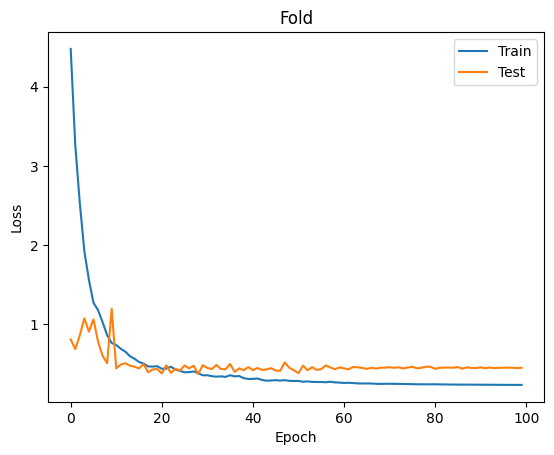

Testing lr: 0.0001
Using device: cuda
Epoch 1, current lr: 0.000100
Epoch 2, current lr: 0.000100
Epoch 3, current lr: 0.000100
Epoch 4, current lr: 0.000100
Epoch 5, current lr: 0.000100
Epoch 6, current lr: 0.000100
Epoch 7, current lr: 0.000100
Epoch 8, current lr: 0.000100
Epoch 9, current lr: 0.000100
Epoch 10, current lr: 0.000100
Epoch 11, current lr: 0.000100
Epoch 12, current lr: 0.000100
Epoch 13, current lr: 0.000100
Epoch 14, current lr: 0.000100
Epoch 15, current lr: 0.000100
Epoch 16, current lr: 0.000100
Epoch 17, current lr: 0.000100
Epoch 18, current lr: 0.000100
Epoch 19, current lr: 0.000080
Epoch 20, current lr: 0.000080
Epoch 21, current lr: 0.000080
Epoch 22, current lr: 0.000080
Epoch 23, current lr: 0.000080
Epoch 24, current lr: 0.000080
Epoch 25, current lr: 0.000064
Epoch 26, current lr: 0.000064
Epoch 27, current lr: 0.000064
Epoch 28, current lr: 0.000064
Epoch 29, current lr: 0.000064
Epoch 30, current lr: 0.000064
Epoch 31, current lr: 0.000051
Epoch 32, 

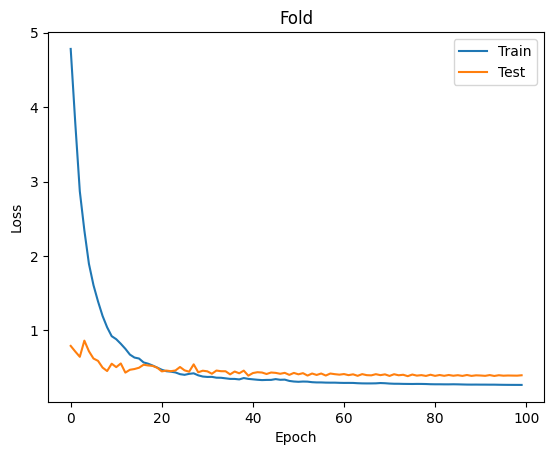

Testing lr: 7e-05
Using device: cuda
Epoch 1, current lr: 0.000070
Epoch 2, current lr: 0.000070
Epoch 3, current lr: 0.000070
Epoch 4, current lr: 0.000070
Epoch 5, current lr: 0.000070
Epoch 6, current lr: 0.000070
Epoch 7, current lr: 0.000070
Epoch 8, current lr: 0.000070
Epoch 9, current lr: 0.000070
Epoch 10, current lr: 0.000070
Epoch 11, current lr: 0.000070
Epoch 12, current lr: 0.000070
Epoch 13, current lr: 0.000070
Epoch 14, current lr: 0.000070
Epoch 15, current lr: 0.000070
Epoch 16, current lr: 0.000070
Epoch 17, current lr: 0.000070
Epoch 18, current lr: 0.000070
Epoch 19, current lr: 0.000070
Epoch 20, current lr: 0.000070
Epoch 21, current lr: 0.000070
Epoch 22, current lr: 0.000070
Epoch 23, current lr: 0.000070
Epoch 24, current lr: 0.000070
Epoch 25, current lr: 0.000070
Epoch 26, current lr: 0.000070
Epoch 27, current lr: 0.000056
Epoch 28, current lr: 0.000056
Epoch 29, current lr: 0.000056
Epoch 30, current lr: 0.000056
Epoch 31, current lr: 0.000056
Epoch 32, c

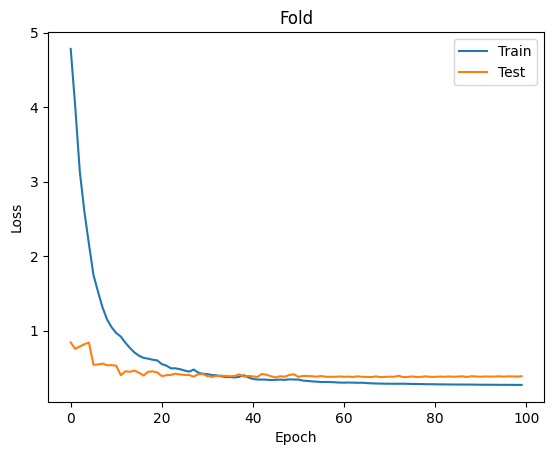

Testing lr: 5e-05
Using device: cuda
Epoch 1, current lr: 0.000050
Epoch 2, current lr: 0.000050
Epoch 3, current lr: 0.000050
Epoch 4, current lr: 0.000050
Epoch 5, current lr: 0.000050
Epoch 6, current lr: 0.000050
Epoch 7, current lr: 0.000050
Epoch 8, current lr: 0.000050
Epoch 9, current lr: 0.000050
Epoch 10, current lr: 0.000050
Epoch 11, current lr: 0.000050
Epoch 12, current lr: 0.000050
Epoch 13, current lr: 0.000050
Epoch 14, current lr: 0.000050
Epoch 15, current lr: 0.000050
Epoch 16, current lr: 0.000050
Epoch 17, current lr: 0.000050
Epoch 18, current lr: 0.000050
Epoch 19, current lr: 0.000050
Epoch 20, current lr: 0.000050
Epoch 21, current lr: 0.000050
Epoch 22, current lr: 0.000050
Epoch 23, current lr: 0.000050
Epoch 24, current lr: 0.000050
Epoch 25, current lr: 0.000050
Epoch 26, current lr: 0.000050
Epoch 27, current lr: 0.000050
Epoch 28, current lr: 0.000050
Epoch 29, current lr: 0.000050
Epoch 30, current lr: 0.000050
Epoch 31, current lr: 0.000050
Epoch 32, c

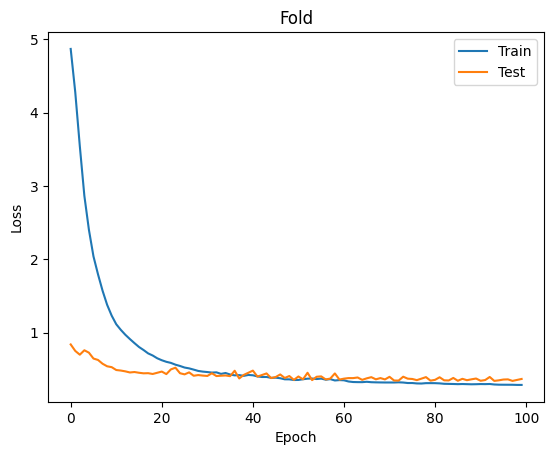

Testing lr: 3e-05
Using device: cuda
Epoch 1, current lr: 0.000030
Epoch 2, current lr: 0.000030
Epoch 3, current lr: 0.000030
Epoch 4, current lr: 0.000030
Epoch 5, current lr: 0.000030
Epoch 6, current lr: 0.000030
Epoch 7, current lr: 0.000030
Epoch 8, current lr: 0.000030
Epoch 9, current lr: 0.000030
Epoch 10, current lr: 0.000030
Epoch 11, current lr: 0.000030
Epoch 12, current lr: 0.000030
Epoch 13, current lr: 0.000030
Epoch 14, current lr: 0.000030
Epoch 15, current lr: 0.000030
Epoch 16, current lr: 0.000030
Epoch 17, current lr: 0.000030
Epoch 18, current lr: 0.000030
Epoch 19, current lr: 0.000030
Epoch 20, current lr: 0.000030
Epoch 21, current lr: 0.000030
Epoch 22, current lr: 0.000030
Epoch 23, current lr: 0.000030
Epoch 24, current lr: 0.000030
Epoch 25, current lr: 0.000030
Epoch 26, current lr: 0.000030
Epoch 27, current lr: 0.000030
Epoch 28, current lr: 0.000030
Epoch 29, current lr: 0.000030
Epoch 30, current lr: 0.000030
Epoch 31, current lr: 0.000030
Epoch 32, c

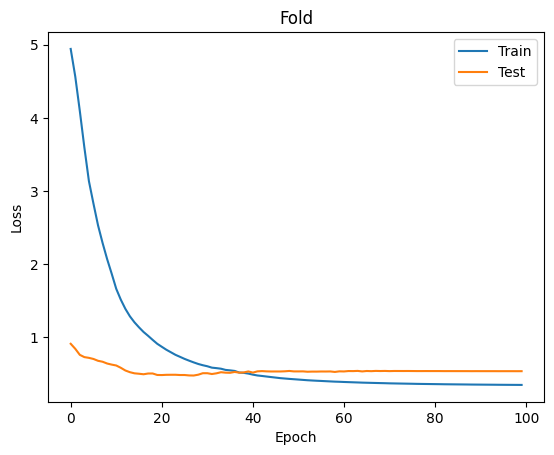

Testing lr: 1e-05
Using device: cuda
Epoch 1, current lr: 0.000010
Epoch 2, current lr: 0.000010
Epoch 3, current lr: 0.000010
Epoch 4, current lr: 0.000010
Epoch 5, current lr: 0.000010
Epoch 6, current lr: 0.000010
Epoch 7, current lr: 0.000010
Epoch 8, current lr: 0.000010
Epoch 9, current lr: 0.000010
Epoch 10, current lr: 0.000010
Epoch 11, current lr: 0.000010
Epoch 12, current lr: 0.000010
Epoch 13, current lr: 0.000010
Epoch 14, current lr: 0.000010
Epoch 15, current lr: 0.000010
Epoch 16, current lr: 0.000010
Epoch 17, current lr: 0.000010
Epoch 18, current lr: 0.000010
Epoch 19, current lr: 0.000010
Epoch 20, current lr: 0.000010
Epoch 21, current lr: 0.000010
Epoch 22, current lr: 0.000010
Epoch 23, current lr: 0.000010
Epoch 24, current lr: 0.000010
Epoch 25, current lr: 0.000010
Epoch 26, current lr: 0.000010
Epoch 27, current lr: 0.000010
Epoch 28, current lr: 0.000010
Epoch 29, current lr: 0.000010
Epoch 30, current lr: 0.000010
Epoch 31, current lr: 0.000010
Epoch 32, c

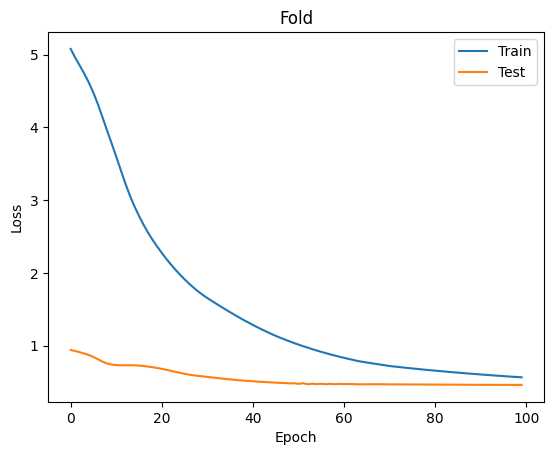

In [8]:
data = load_data_from_db()
# input_size = X[0].shape[1]
# output_size = Y[0].shape[1]
# random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)

X, Y = create_x_y(data)
input_size = X[0].shape[1]
output_size = Y[0].shape[1]

# scaler_X, scaler_Y = create_scalers(X,Y)

# X_scaled, Y_scaled = scale_input(X,Y,scaler_X,scaler_Y)

# X_scaled = [scaler_X.transform(np.array(race)) for race in X]
# Y_scaled = [scaler_Y.transform(np.array(race)) for race in Y]



loo = LeaveOneOut()
all_fold_train = []
all_fold_test = []
all_fold_r2_test = []
i = 0

lrs = [1e-3,1e-3,1e-3, 7e-4, 5e-4, 3e-4, 1e-4, 7e-5, 5e-5, 3e-5, 1e-5]
# lr = 7e-5
# lr = 5e-4
# batch_sizes = [32, 64, 128, 256, 512]
batch_size = 128
# num_epochs = [50, 100, 150, 200, 300, 400]
num_epochs = 100
weights = [
    [1.0, 1.0, 1.0, 1.0, 1.0],
    [0.8, 1.2, 1.5, 0.5, 1.0],
    [0.7, 1.4, 2.0, 0.3, 1.2],
    [0.6, 1.6, 2.5, 0.2, 1.3],
    [0.5, 1.8, 3.0, 0.1, 1.5]
]
weight = weights[0]  # wybierz zestaw wag do testowania
for lr in lrs:
    print("Testing lr:", lr)
    for fold, (train_idx, test_idx) in enumerate(loo.split(X)):
        
        if fold > 0:
            break
        i += 1
    

        X_train = [X[i] for i in train_idx]
        X_test  = [X[i] for i in test_idx]
        Y_train = [Y[i] for i in train_idx]
        Y_test  = [Y[i] for i in test_idx]

        Y_train_raw = [np.array(y, copy=True) for y in Y_train]  # zapisz oryginalne (nieprzeskalowane)


        # Y_train_raw = Y_train.copy()  # zachowaj surowe Y_train przed skalowaniem

        scaler_X, scaler_Y = create_scalers(X_train,Y_train)

        X_train, Y_train = scale_input(X_train,Y_train,scaler_X,scaler_Y)
        X_test, Y_test = scale_input(X_test,Y_test,scaler_X,scaler_Y)
        n_steps_ahead = 5  # number of future steps to predict


        all_X, all_Y = [], []
        for race_x, race_y in zip(X_train, Y_train):  
            X_r, Y_r = create_windows(race_x, race_y, window_size=30, n_steps_ahead=n_steps_ahead)
            all_X.append(X_r)
            all_Y.append(Y_r)

        X_train = np.vstack(all_X)  # shape: [N_samples, window_size, n_features]
        Y_train = np.vstack(all_Y) 
        all_X, all_Y = [], []
        for race_x, race_y in zip(X_test, Y_test):  
            X_r, Y_r = create_windows(race_x, race_y, window_size=30)
            all_X.append(X_r)
            all_Y.append(Y_r)
        X_test = np.vstack(all_X)  # shape: [N_samples, window_size, n_features]
        Y_test = np.vstack(all_Y)


        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Using device:", device)
        model = LSTMStatePredictor(input_size=input_size, hidden_size=128, output_size=output_size,n_steps_ahead=n_steps_ahead, num_layers=1).to(device)



        
        
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).to(device)

        train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        # optimizer = optim.Adam(model.parameters(), lr=lr)
        

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5)
        loss_cont = nn.MSELoss()
        loss_cat  = nn.CrossEntropyLoss()

        fold_train_losses = []
        fold_test_losses = []
        # num_epochs = 100
        all_r2_per_output = []
        fold_r2_scores = []

        
        
        for epoch in range(num_epochs):
            
            model.train()
            total_loss = 0

            # weights = torch.tensor(
            #     [0.8, 0.8, 2.0, 1.5, 1.5, 1.5, 1.5, 0.1, 0.1, 0.1, 0.1, 3.0],
            #     dtype=torch.float32,
            #     device=device
            # )

            for x_batch, y_batch in train_loader:
                optimizer.zero_grad()
                pred = model(x_batch)
                
                # bierzemy ostatni krok z predykcji (lub całość, jeśli tak trenujesz)
                pred_flat = pred[:, -1, :]
                y_flat = y_batch[:, -1, :]
                # rozbijanie po grupach
                loss_progress = loss_cont(pred_flat[:, 0:2], y_flat[:, 0:2])
                loss_fuel     = loss_cont(pred_flat[:, 2:3], y_flat[:, 2:3])
                loss_wear     = loss_cont(pred_flat[:, 3:7], y_flat[:, 3:7])
                loss_temp     = loss_cont(pred_flat[:, 7:11], y_flat[:, 7:11])
                loss_wet      = loss_cont(pred_flat[:, 11:], y_flat[:, 11:])
                # łączymy straty z różnych grup z różnymi wagami
                loss =  weight[0] * loss_progress + \
                        weight[1] * loss_fuel + \
                        weight[2] * loss_wear + \
                        weight[3] * loss_temp + \
                        weight[4] * loss_wet
                # łączenie z wagami
                # loss = (0.8 * loss_progress +
                #         1.2 * loss_fuel +
                #         1.5 * loss_wear +
                #         0.5 * loss_temp +
                #         1.0 * loss_wet)

                # standardowy update
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            fold_train_losses.append(total_loss / len(train_loader))

            model.eval()
            with torch.no_grad():
                pred_test = model(X_test_tensor)
                test_loss = loss_cont(pred_test, Y_test_tensor).item()
                fold_test_losses.append(test_loss)
            
                scheduler.step(test_loss)
                print(f"Epoch {epoch+1}, current lr: {optimizer.param_groups[0]['lr']:.6f}")

                
                if epoch == num_epochs - 1:
                    b, t, f = pred_test.shape
                    pred_test_flat = pred_test.cpu().numpy().reshape(b*t, f)
                    Y_test_flat = Y_test_tensor.cpu().numpy().reshape(b*t, f)

                    # inverse transform
                    pred_test_inv = scaler_Y.inverse_transform(pred_test_flat)
                    Y_test_inv = scaler_Y.inverse_transform(Y_test_flat)

                    # R² po cechach
                    r2s = [r2_score(Y_test_inv[:, i], pred_test_inv[:, i]) for i in range(f)]
                    avg_r2_per_output = np.mean(r2s)
                    print("Avg R2 per output:", r2s)
                    print("Mean R2:", avg_r2_per_output)

                    # === DIAGNOSTYKA PER-FEATURE ===
                    from sklearn.metrics import mean_squared_error
                    print("\n--- DIAGNOSTYKA ---")

                    # przygotuj dane surowe z treningu (przed skalowaniem!)
                    # jeśli chcesz pełną dokładność, przechowuj Y_train_raw = Y_train (niezeskalowane) tuż po wczytaniu
                    # tu tymczasowo przyjmujemy, że masz Y_train nieprzeskalowane dostępne jako oryginalne dane:
                    flat_y_train = np.vstack([y for y in Y_train_raw])  # jeśli Y_train jest już scaled, zmień to na surowe Y_train_raw

                    vars_train = flat_y_train.var(axis=0)
                    means_train = flat_y_train.mean(axis=0)
                    mins = flat_y_train.min(axis=0)
                    maxs = flat_y_train.max(axis=0)

                    print("Feature | var | mean | min | max")
                    for i in range(f):
                        print(i, round(vars_train[i],6), round(means_train[i],6), round(mins[i],6), round(maxs[i],6))

                    # baseline R² (predykcja średnią z train)
                    mean_pred = np.tile(means_train.reshape(1,-1), (Y_test_inv.shape[0],1))
                    baseline_r2 = [r2_score(Y_test_inv[:,i], mean_pred[:,i]) for i in range(f)]
                    print("\nBaseline R2 per feature:", baseline_r2)

                    # model R² + MSE + min/max pred
                    for i in range(f):
                        r2 = r2_score(Y_test_inv[:,i], pred_test_inv[:,i])
                        mse = mean_squared_error(Y_test_inv[:,i], pred_test_inv[:,i])
                        print(f"feat {i}: R2={r2:.4f}, MSE={mse:.6f}, pred_min={pred_test_inv[:,i].min():.4f}, pred_max={pred_test_inv[:,i].max():.4f}")
                    print("--- KONIEC DIAGNOSTYKI ---\n")
            
        plt.figure()
        plt.plot(fold_train_losses, label='Train')
        plt.plot(fold_test_losses, label='Test')
        plt.title(f'Fold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    
    del model, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor
    torch.cuda.empty_cache()

    # if i == 1:
    #     break

                # opcjonalnie: wróć do kształtu 3D, jeśli chcesz generować sekwencje
                # pred_test_inv = pred_test_inv.reshape(b, t, f)
                # Y_test_inv    = Y_test_inv.reshape(b, t, f)


        
    # all_fold_train.append(fold_train_losses)
    # all_fold_test.append(fold_test_losses)
    # # all_fold_r2.append(fold_r2_scores)

    # # Compute R^2 score for the test set
    # r2 = r2_score(Y_test_tensor.cpu().numpy(), pred_test.cpu().numpy())
    # all_fold_r2_test.append(r2)


In [ ]:
def create_window_pred(sequence_x, window_size, n_steps_ahead=5):
    X, Y = [], []
    curr_len = len(sequence_x)

    # for t in range(1, len(sequence_x)):
    start = max(0, curr_len - window_size)
    window = sequence_x[start:curr_len]

    # padding na początku, jeśli okno krótsze niż window_size
    pad_len = window_size - len(window)
    if pad_len > 0:
        window = np.vstack([np.zeros((pad_len, sequence_x.shape[1])), window])
    X.append(window)

        

    return np.array(X)

Generate state predictions

In [ ]:
del X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor
window_size = 30
X_init = X_test[0]  
print(X_init)  # skalowane
# current_window = torch.tensor(X_init, dtype=torch.float32).unsqueeze(0).to(device)
race_states = []
race_states.append(X_init)
current_window = create_window_pred(race_states,window_size=window_size)
current_window = torch.tensor(current_window, dtype=torch.float32).to(device)
model.eval()
for _ in range(1000):
    with torch.no_grad():
        pred_test = model(current_window)
        print(pred_test)
        
        race_states.append(pred_test.cpu().numpy())
        current_window = create_window_pred(race_states, window_size=window_size)
        current_window = torch.tensor(current_window, dtype=torch.float32).to(device)

        pred_test_inv = scaler_Y.inverse_transform(pred_test.cpu().numpy())
        Y_test_inv = scaler_Y.inverse_transform(current_window.squeeze(0).cpu().numpy())



In [ ]:
# num_features = y_cont_orig.shape[1]
# plt.figure(figsize=(15, 3 * num_features))
# titles = ['Lap progress','Race progress', 'Fuel level', 'Wheel1 wear', 'Wheel2 wear', 'Wheel3 wear', 'Wheel4 wear', 'Wheel1 temp','Wheel2 temp','Wheel3 temp','Wheel4 temp','AvgPathWetness']
# for i in range(num_features):
#     plt.subplot(num_features, 1, i + 1)
#     plt.plot(y_cont_orig[:, i], label='Rzeczywiste')
#     plt.plot(cont_pred_orig[:, i], label='Predykcja', linestyle='--')
#     plt.title(f'{titles[i]}')
#     plt.legend()



# plt.tight_layout()
# plt.show()

In [ ]:
del model, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor
torch.cuda.empty_cache()

Visualize var to generate by alghoritm(weather,damages,itd)

In [ ]:
# Nazwy cech według Twojego opisu
feature_names = [
    "mLastImpactET",
    "mLastImpactMagnitude",
    "mNumPenalties",
    "mRaining",
    "mAmbientTemp",
    "mTrackTemp",
    "mDentSeverity[0]",
    "mDentSeverity[1]",
    "mDentSeverity[2]",
    "mDentSeverity[3]",
    "mDentSeverity[4]",
    "mDentSeverity[5]",
    "mDentSeverity[6]",
    "mDentSeverity[7]",
    "has_last_lap",
    "mFinishStatus",
    "mTotalLaps",
    "mSector",
    "mNumPitstops",
    "mInPits",
    "mFrontTireCompoundIndex",
    "multiplier"
]

# Jeśli masz mniej niż 24 nazw, dodaj puste lub dopisz brakujące
while len(feature_names) < 24:
    feature_names.append(f"Feature {len(feature_names)}")

data = load_data_from_db()
race = np.array(data[1])  # pierwszy wyścig
last_24_features = race[:, -24:]  # shape: [liczba_kroków, 24]

for i in range(24):
    plt.figure(figsize=(10, 3))
    plt.plot(last_24_features[:, i])
    plt.title(f"{feature_names[i]}")
    plt.xlabel("Krok")
    plt.ylabel("Wartość")
    plt.tight_layout()
    plt.show()

data = load_data_from_db()
num_features = 24

# Inicjalizacja list na min i max dla każdej cechy
feature_mins = [float('inf')] * num_features
feature_maxs = [float('-inf')] * num_features

for race in data:
    race = np.array(race)
    last_24_features = race[:, -num_features:]  # shape: [liczba_kroków, 24]
    for i in range(num_features):
        feature_min = np.min(last_24_features[:, i])
        feature_max = np.max(last_24_features[:, i])
        if feature_min < feature_mins[i]:
            feature_mins[i] = feature_min
        if feature_max > feature_maxs[i]:
            feature_maxs[i] = feature_max

for i in range(num_features):
    print(f"{feature_names[i]}: min={feature_mins[i]}, max={feature_maxs[i]}")






In [ ]:
race = np.array(data[0])  # pierwszy wyścig

lap_distance = race[:, 0]  # podaj właściwy indeks dystansu okrążenia
sector = race[:, 29]
print("Unikalne sektory:", np.unique(sector))

for i in range(1, len(race)):
    if sector[i] != sector[i-1]:
        print(f"Sektor zmienił się na {sector[i]} przy dystansie {lap_distance[i]}")

In [ ]:
impact_magnitudes = []

for race in data:
    race = np.array(race)
    # Zakładam, że mLastImpactMagnitude to jedna z ostatnich 24 cech, np. indeks 1
    impact_magnitudes.extend(race[:, -23])  # -23 jeśli to druga cecha z końca, popraw jeśli inny indeks

impact_magnitudes = np.array(impact_magnitudes)

plt.figure(figsize=(8, 4))
plt.hist(impact_magnitudes, bins=90, color='skyblue', edgecolor='black')
plt.title("Rozkład siły uderzenia (mLastImpactMagnitude)")
plt.xlabel("Siła uderzenia")
plt.ylabel("Liczba przypadków")
plt.tight_layout()
plt.show()


# Zbierz wszystkie wartości siły uderzenia
impact_magnitudes = []
for race in data:
    race = np.array(race)
    impact_magnitudes.extend(race[:, -23])  # -23 jeśli to druga cecha z końca

impact_magnitudes = np.array(impact_magnitudes)

# Policz histogram (np. 20 przedziałów)
hist, bin_edges = np.histogram(impact_magnitudes, bins=90, density=True)
print("Bin edges:", bin_edges)
probabilities = hist / hist.sum()  # prawdopodobieństwa dla każdego przedziału
print(probabilities)

np.save('E:/pracadyp/Race-optimization-reinforcement-learning/data/probabilities_impact/probabilities.npy', probabilities)
np.save('E:/pracadyp/Race-optimization-reinforcement-learning/data/probabilities_impact/bin_edges.npy', bin_edges)


In [ ]:
data = load_data_from_db()
num_features = 36

# Inicjalizacja list na min i max dla każdej cechy
feature_mins = [float('inf')] * num_features
feature_maxs = [float('-inf')] * num_features

for race in data:
    race = np.array(race)
    all_features = race[:, -num_features:]  # shape: [liczba_kroków, 36]
    for i in range(num_features):
        feature_min = np.min(all_features[:, i])
        feature_max = np.max(all_features[:, i])
        if feature_min < feature_mins[i]:
            feature_mins[i] = feature_min
        if feature_max > feature_maxs[i]:
            feature_maxs[i] = feature_max

for i in range(num_features):
    print(f": min={feature_mins[i]}, max={feature_maxs[i]}")